In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

C:\Users\jelle\AppData\Local\Temp\ipykernel_19124\2796162548.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../label/100_random_labelled.csv')
df.head()

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment
0,2020-07-24T06:47:07Z,Kansas,@WhiteHouse @realDonaldTrump Since trump cance...,Twitter Web App,279,en,2,0,False,25,23,0,24,15,Since trump cancelled his convention in Jack...,8,'true'
1,2020-07-23T16:53:44Z,Washington,@drchethansathya 9 year old died in Florida fr...,Twitter for iPhone,189,en,0,0,False,21,168,0,3809,6043,9 year old died in Florida from COVID this we...,8,True
2,2020-07-23T13:10:22Z,Ohio,If trump decides he won’t leave the White Hous...,Twitter for iPhone,268,en,0,0,False,68,97,3,757,664,If trump decides he won’t leave the White Hous...,9,'No verdict'
3,2020-07-22T02:03:52Z,Ohio,"Ao now we have ""the Trump virus"" and the ""Skan...",Twitter Web App,52,en,0,0,True,2995,3073,1,8741,7807,"Ao now we have ""the Trump virus"" and the ""Skan...",8,False
4,2020-07-24T17:21:52Z,Minnesota,@AustinOnSocial That two seconds I spend tryin...,Twitter for iPhone,124,en,0,0,False,99,402,2,9648,4129,That two seconds I spend trying to ace this q...,8,'no verdict'


In [3]:
df['Fact assessment'].value_counts()

Fact assessment
'no verdict'    49
False           17
'true'          12
No verdict      12
'false'          5
True             2
'No verdict'     2
false            1
Name: count, dtype: int64

In [4]:
df['fake_binary'] = ((df['Fact assessment'] == 'false') | 
                    (df['Fact assessment'] == 'False') | 
                    (df['Fact assessment'] == "'False'") | 
                    (df['Fact assessment'] == "'false'")).rename('fake_binary').astype(int)
df['fake_binary'].value_counts()

fake_binary
0    77
1    23
Name: count, dtype: int64

In [5]:
df['source'].value_counts()

source
Twitter for iPhone     41
Twitter Web App        27
Twitter for Android    27
Twitter for iPad        4
LinkedIn                1
Name: count, dtype: int64

In [6]:
apple_binary = df['source'].apply(lambda x: 1 if x in ['Tweetbot for Mac',
                                                            'Tweetbot for iΟS',
                                                            'Twitter for Mac',
                                                            'Twitter for iPad',
                                                            'Twitter for iPhone',
                                                            'Twitterrific for iOS'] else 0).rename('apple_binary').astype(int)
apple_binary.value_counts()

apple_binary
0    55
1    45
Name: count, dtype: int64

In [7]:
state_dummies = pd.get_dummies(df, columns=['state_likely_tweeted_from'],drop_first=True)
# Filtering to get just the state dummy columns
state_columns = [col for col in state_dummies.columns if col.startswith('state_likely_tweeted_from_')]
states_matrix = state_dummies[state_columns].astype(int)
states_matrix

,state_likely_tweeted_from_Arizona,state_likely_tweeted_from_California,state_likely_tweeted_from_Colorado,state_likely_tweeted_from_Florida,state_likely_tweeted_from_Georgia,state_likely_tweeted_from_Kansas,state_likely_tweeted_from_Maine,state_likely_tweeted_from_Michigan,state_likely_tweeted_from_Minnesota,state_likely_tweeted_from_Missouri,...,state_likely_tweeted_from_Oklahoma,state_likely_tweeted_from_Oregon,state_likely_tweeted_from_Pennsylvania,state_likely_tweeted_from_Tennessee,state_likely_tweeted_from_Texas,state_likely_tweeted_from_Utah,state_likely_tweeted_from_Virginia,state_likely_tweeted_from_Washington,state_likely_tweeted_from_West Virginia,state_likely_tweeted_from_Wisconsin
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df['likes_per_1000followers'] = ((df['favorite_count'] / df['followers_count']) * 1000).astype(int)
df['likes_per_1000followers'].describe()

count    100.000000
mean      10.790000
std       45.083154
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      363.000000
Name: likes_per_1000followers, dtype: float64

In [9]:
df = df[['fake_binary', 'retweet_count', 'favorite_count', 
       'is_quote', 'friends_count', 'followers_count', 
       'statuses_count', 'likes_per_1000followers', 'Toxicity']].astype(int)
df

,fake_binary,retweet_count,favorite_count,is_quote,friends_count,followers_count,statuses_count,likes_per_1000followers,Toxicity
0,0,0,2,0,23,25,24,80,8
1,0,0,0,0,168,21,3809,0,8
2,0,0,0,0,97,68,757,0,9
3,1,0,0,1,3073,2995,8741,0,8
4,0,0,0,0,402,99,9648,0,8
...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,21,2,452,0,9
96,0,0,0,0,965,849,11858,0,3
97,0,0,0,0,66,15,25,0,7
98,1,0,1,0,2119,930,24284,1,7


In [10]:
YX = pd.concat([df, states_matrix, apple_binary], axis=1) 
X = YX.drop(columns='fake_binary')
y = YX[['fake_binary']]

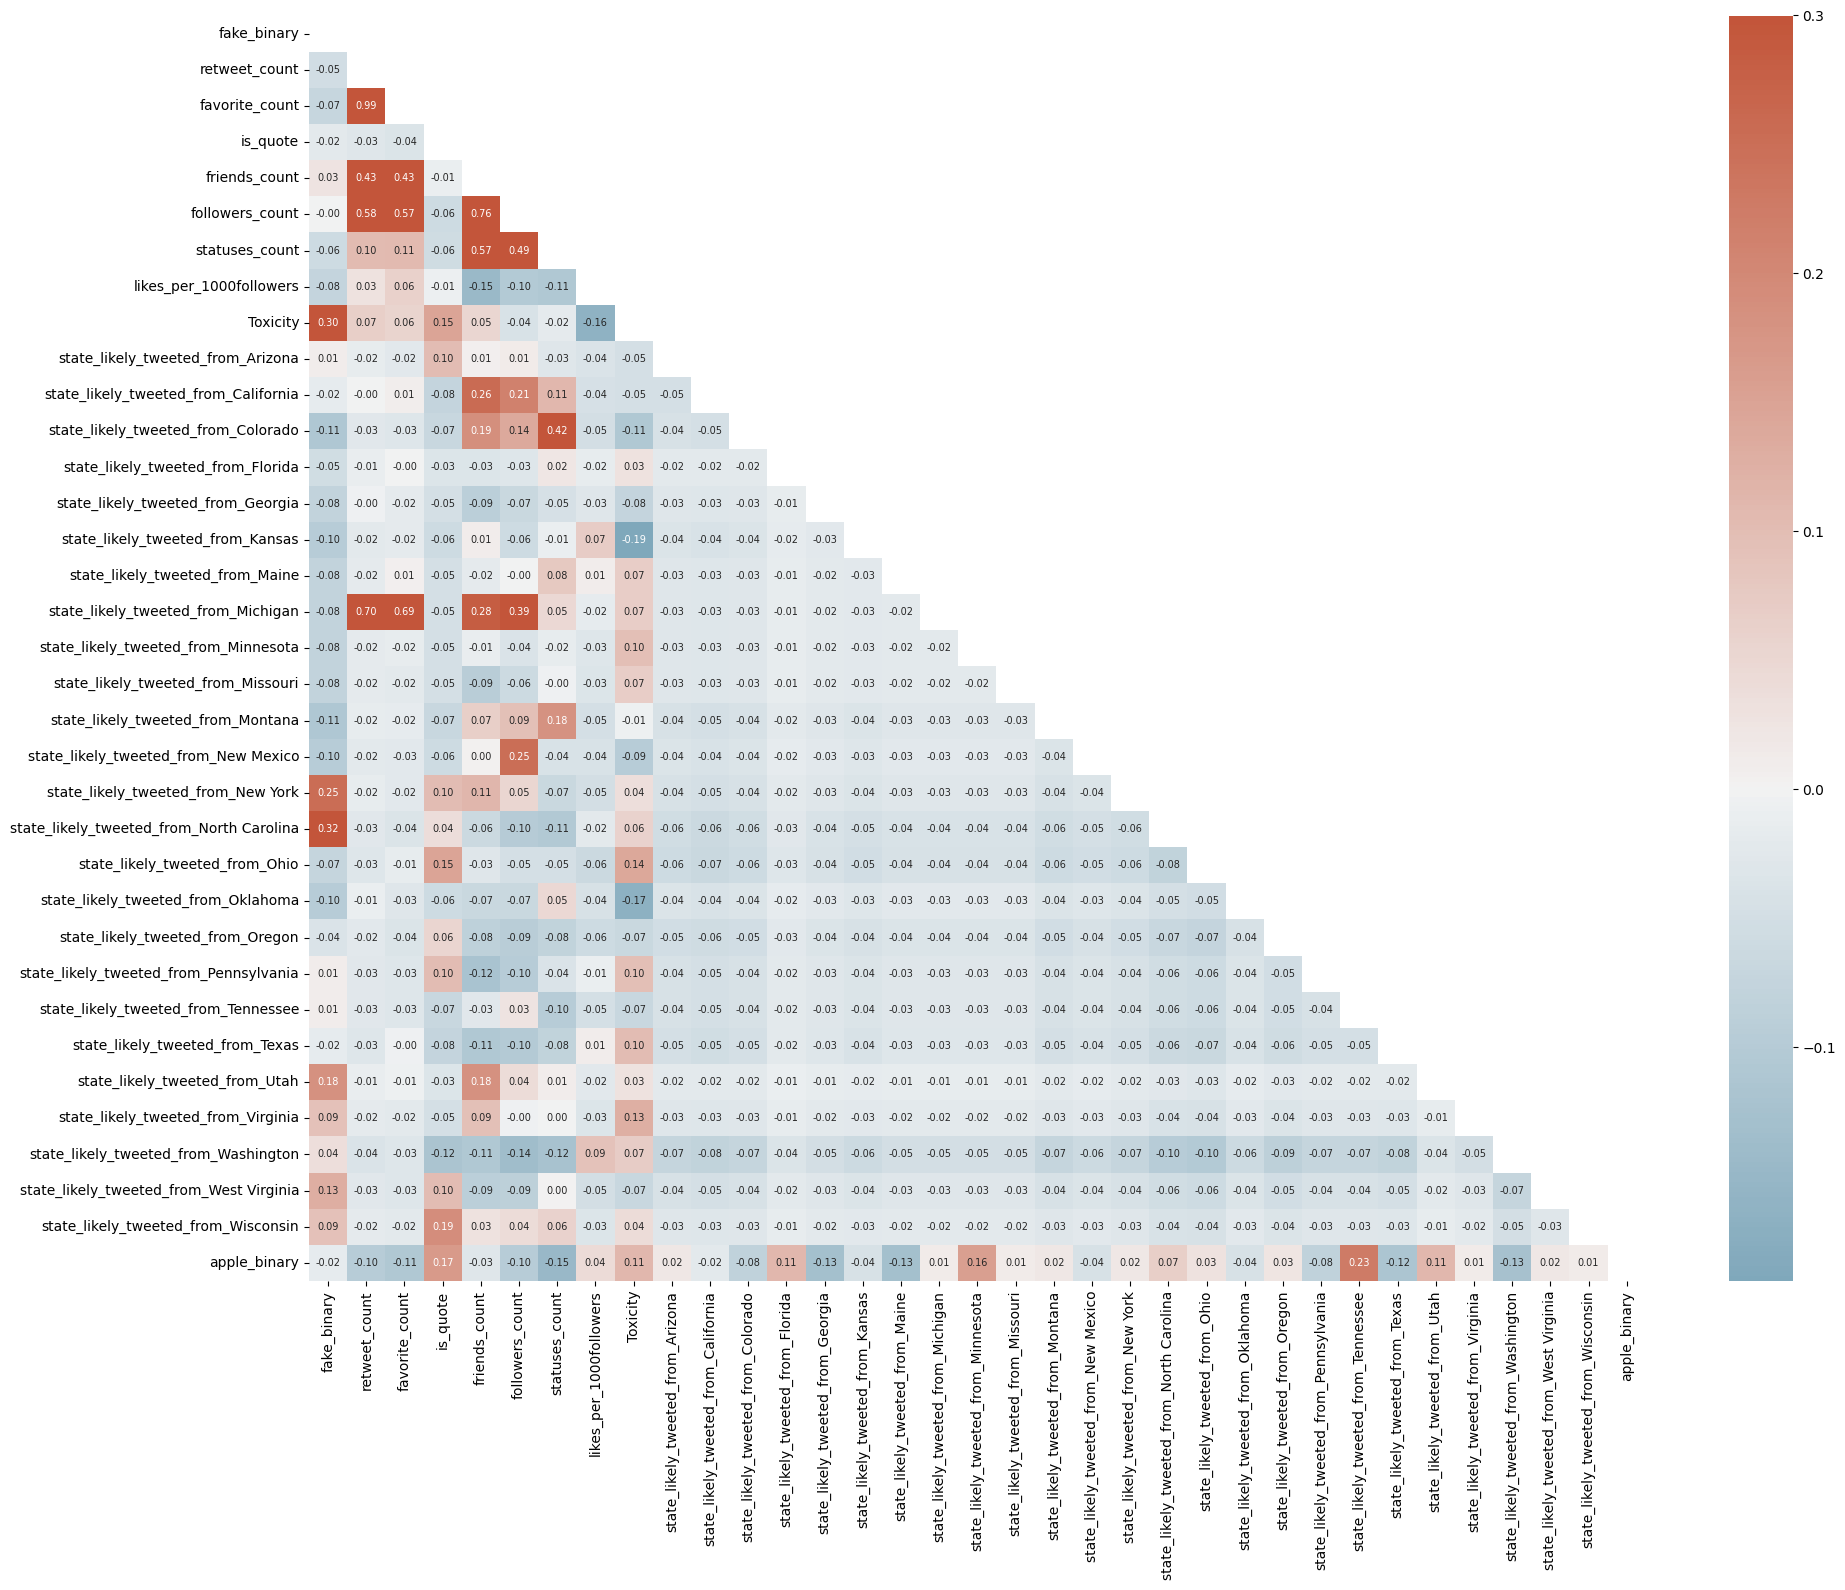

In [11]:
# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

In [12]:
# Add constant
X_const = sm.add_constant(X)

# Split data into 75% training and 25% test sets
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.25, random_state=42)

YX_train = pd.concat([y_train, X_train], axis=1)
YX_test = pd.concat([y_test, X_test], axis=1)

In [13]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_const.columns if (col not in states_matrix.columns.to_list()) and (col != 'likes_per_1000followers')],
    'c': [col for col in X_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['followers_count', 'favorites_count'])]
#    'd': X_const.columns.tolist() # add this with more data, doesnt work now
}

In [14]:
predictors

{'a': ['const'],
 'b': ['const',
  'retweet_count',
  'favorite_count',
  'is_quote',
  'friends_count',
  'followers_count',
  'statuses_count',
  'Toxicity',
  'apple_binary'],
 'c': ['const',
  'retweet_count',
  'favorite_count',
  'is_quote',
  'friends_count',
  'statuses_count',
  'likes_per_1000followers',
  'Toxicity',
  'apple_binary']}

In [15]:
y = YX_train['fake_binary'] # Target variable

# Define K
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_train):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_train.iloc[train_index][cols], YX_train.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    print(average_brier_score)
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                   60
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            0
Date:                Sat, 23 Mar 2024   Pseudo R-squ.:               2.445e-11
Time:                        16:13:52   Log-Likelihood:                -28.585
converged:                       True   LL-Null:                       -28.585
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4939      0.334     -4.478      0.000      -2.148      -0.840
                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observat

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                   60
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            0
Date:                Sat, 23 Mar 2024   Pseudo R-squ.:               1.568e-11
Time:                        16:13:52   Log-Likelihood:                -23.560
converged:                       True   LL-Null:                       -23.560
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8718      0.380     -4.929      0.000      -2.616      -1.127
                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observat

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                   60
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            8
Date:                Sat, 23 Mar 2024   Pseudo R-squ.:                  0.2199
Time:                        16:13:52   Log-Likelihood:                -21.090
converged:                      False   LL-Null:                       -27.034
Covariance Type:            nonrobust   LLR p-value:                    0.1563
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.4355      2.105     -2.582      0.010      -9.561      -1.310
retweet_count       0.2478      1.308      0.189      0.850      -2.315       2.811
favorite_count     -0.1384      

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.147889,0.826667,0.500000,57.115019
1,b,0.197804,0.786667,0.475433,64.946918
2,c,0.167639,0.786667,0.600000,65.700064


Looking at this the current models are pretty trash, I will use c for the further evaluation, because a might not be the most representative in case we figure out variables that work better (topics etc.) or simply have more data.

In [17]:
# Now fit the model to the full validation set
model = sm.Logit(YX_train['fake_binary'], YX_train[predictors['c']]).fit()

Optimization terminated successfully.
         Current function value: 0.409241
         Iterations 9


In [18]:
# Get summary results 
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                   75
Model:                          Logit   Df Residuals:                       66
Method:                           MLE   Df Model:                            8
Date:                Sat, 23 Mar 2024   Pseudo R-squ.:                  0.1125
Time:                        16:17:38   Log-Likelihood:                -30.693
converged:                       True   LL-Null:                       -34.585
Covariance Type:            nonrobust   LLR p-value:                    0.4549
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.5939      1.340     -2.682      0.007      -6.220      -0.968
retweet_count               0.3842      0.931      0.413      0.680      -1.440       2.209


In [19]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [21]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_test[predictors['c']], beta_simulation)
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

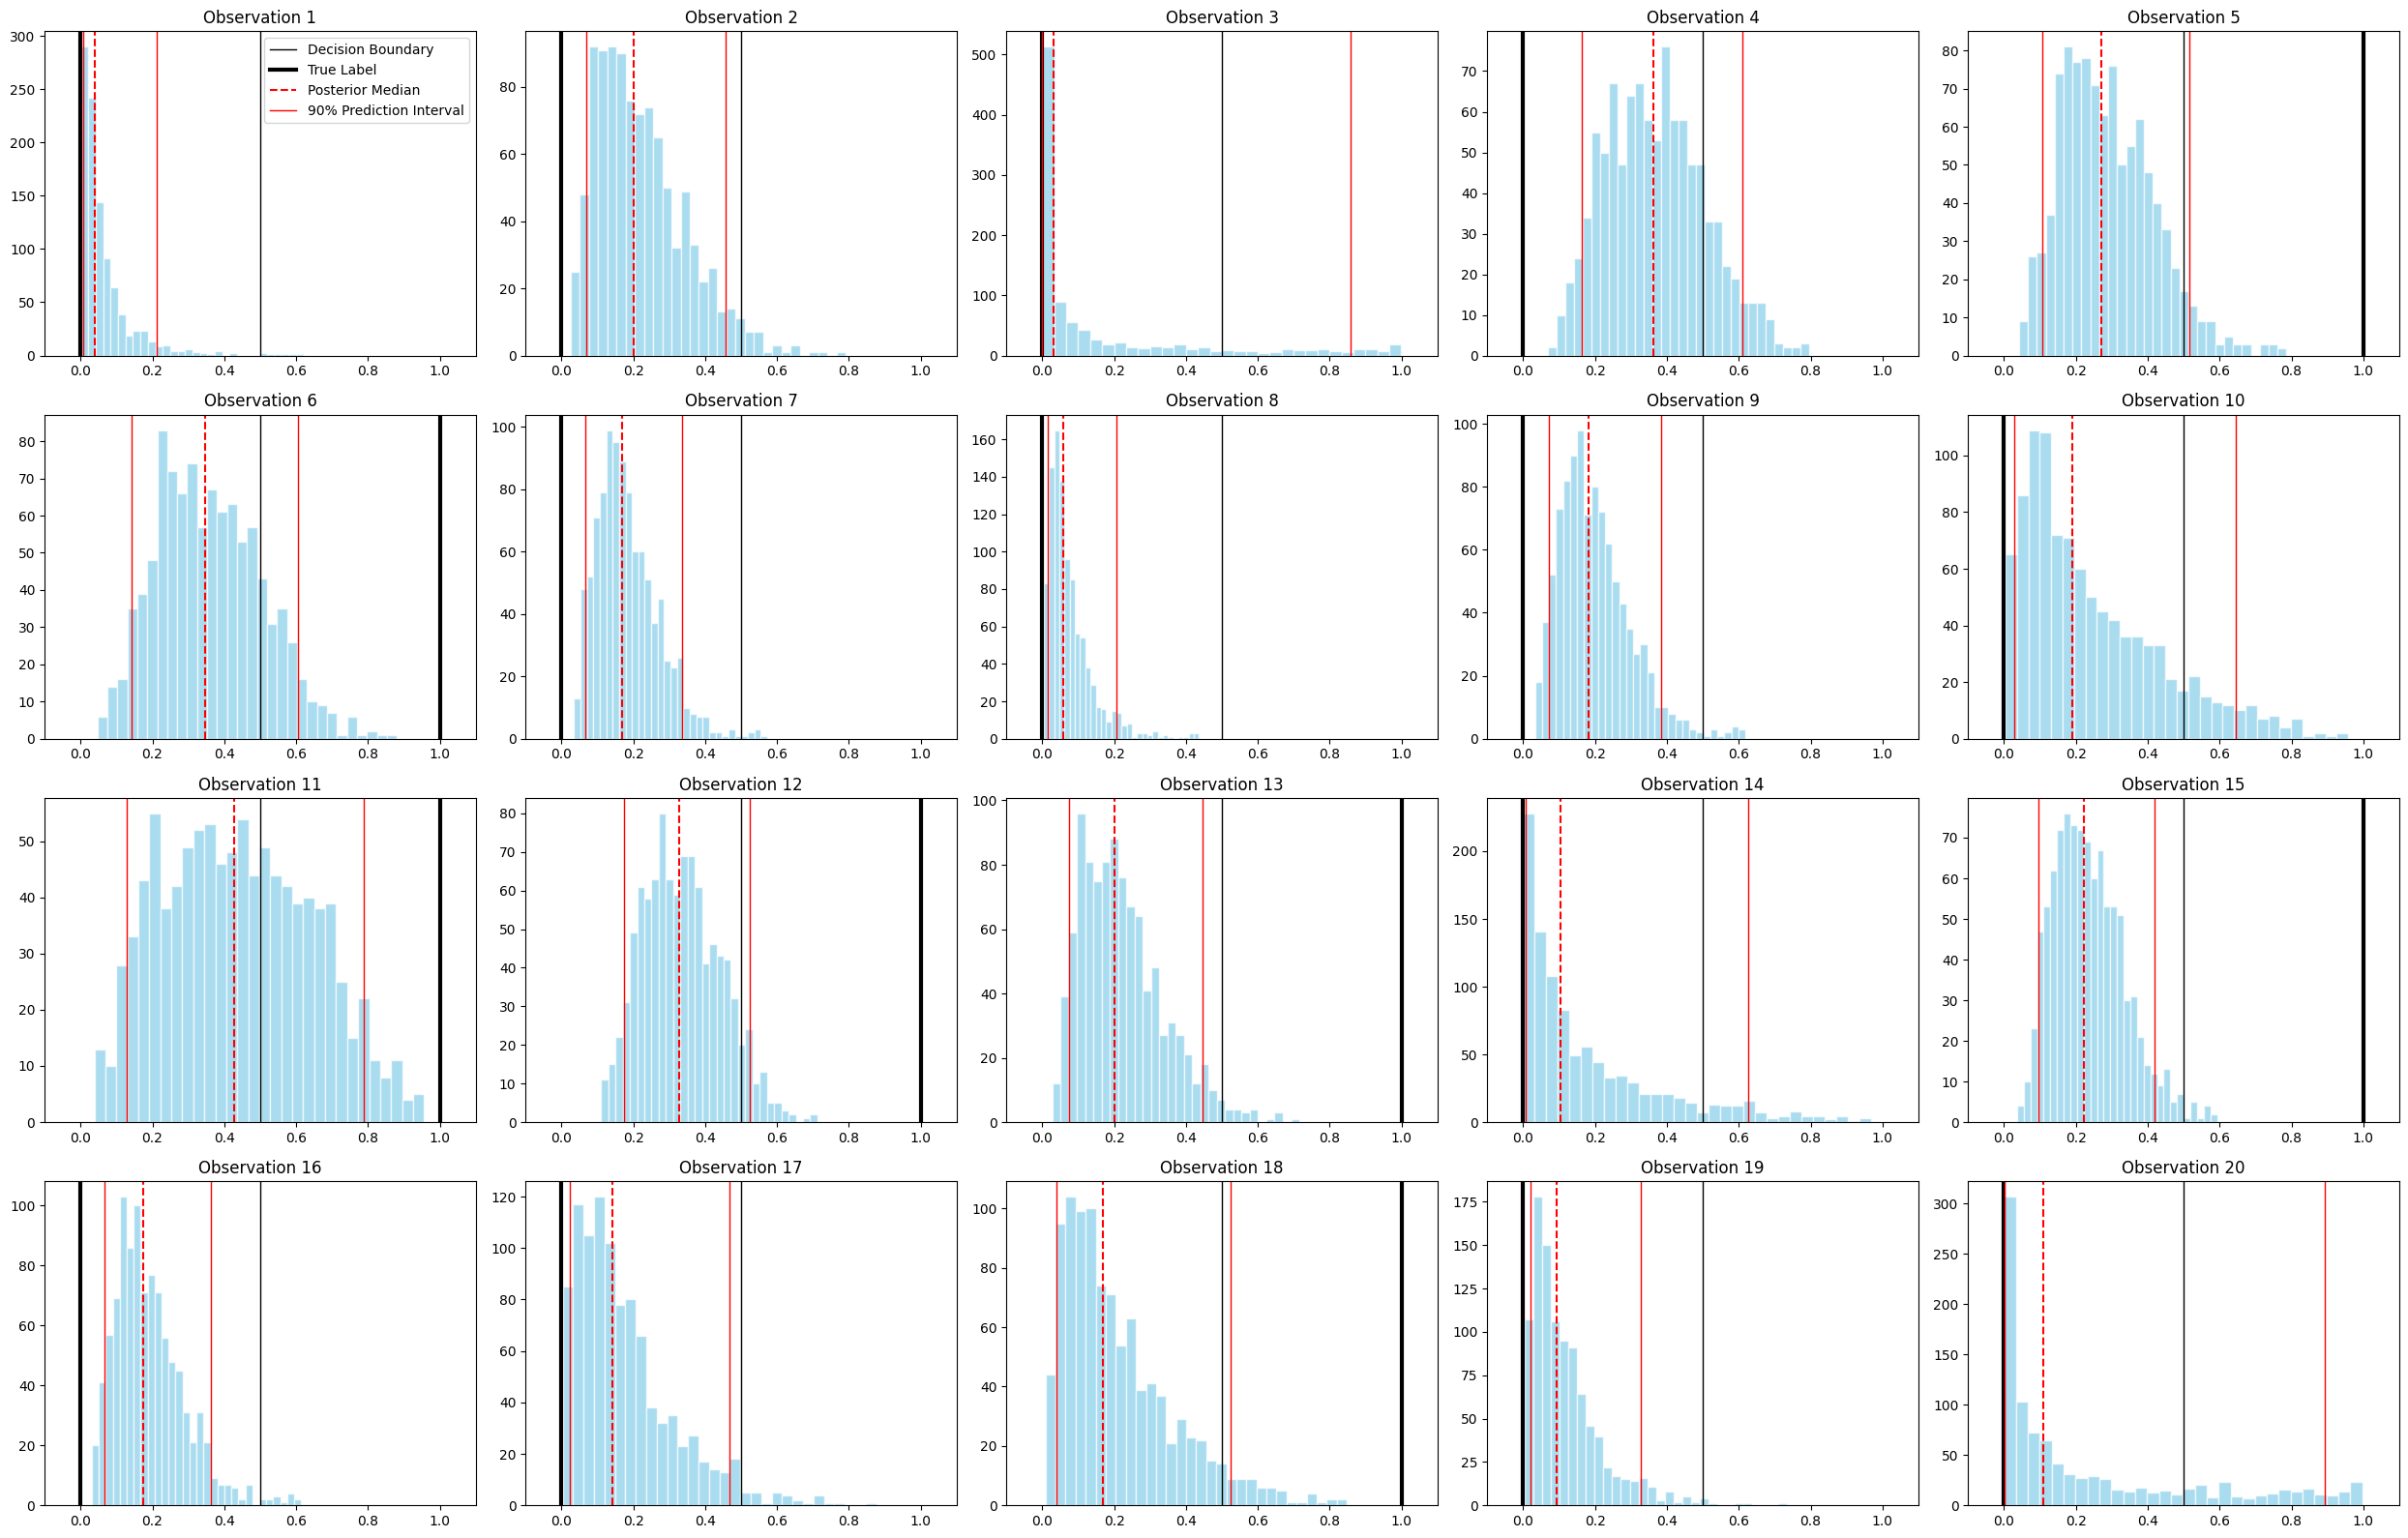

In [23]:
true_labels = YX_test['fake_binary']

# Calculate posterior median and the 90% prediction interval for each of the first 10 observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

In [24]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

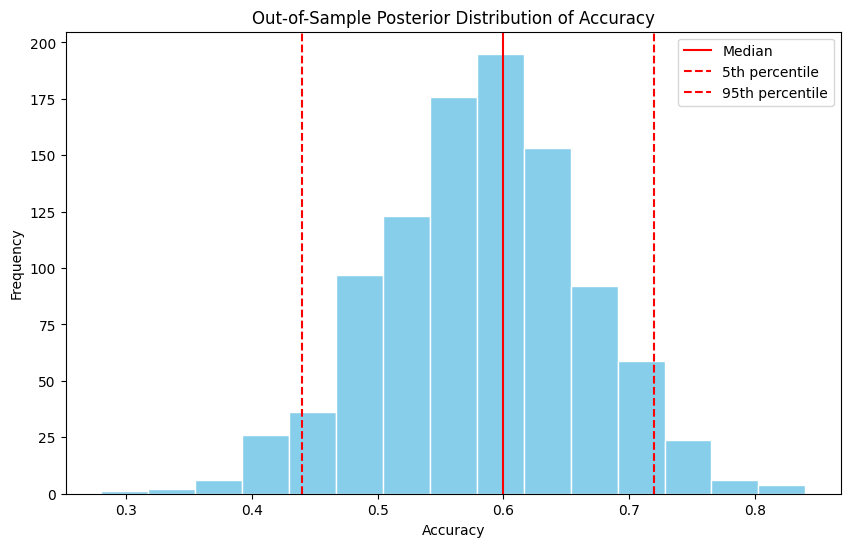

In [28]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

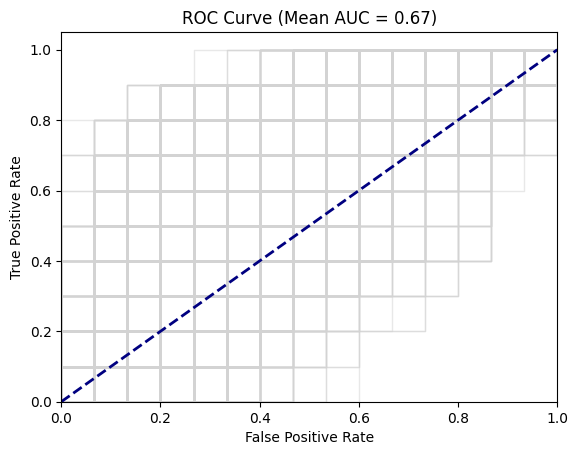

In [29]:
# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

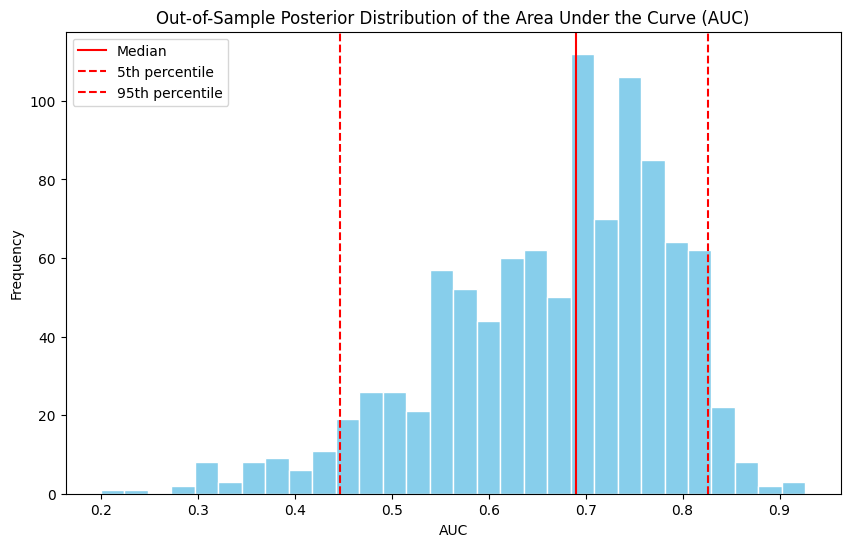

In [30]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(aucs), color='red', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

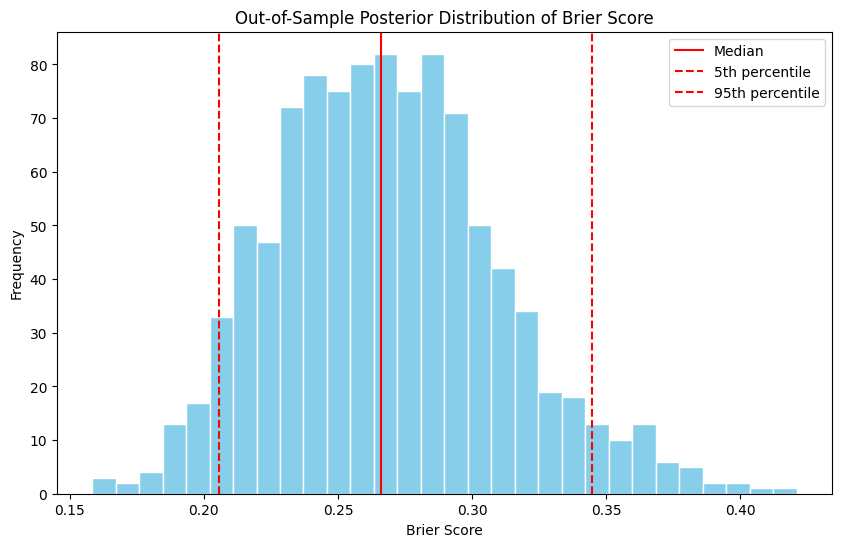

In [31]:
# Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(briers), color='red', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()
